In [1]:
%load_ext autoreload
%autoreload 2

## Compile Cython code and load libraries

In [5]:
import os

# remove previous version of Cython functions if exists
if 'build' in os.listdir('.'):
    LIB_PATH = 'build/' + os.listdir('build')[0] + '/src/optimize.o'

    !rm src/optimize.o src/optimize.c
    !rm -r build
    
# Compiling cython code
!python setup.py build_ext --inplace

# Copy library to src folder
!cp $LIB_PATH src

# Check src folder
!ls -a src

running build_ext
building 'optimize' extension
creating build
creating build/temp.linux-x86_64-3.9
creating build/temp.linux-x86_64-3.9/src
gcc -pthread -B /home/sergei/Programms/anaconda3/envs/gt/compiler_compat -Wl,--sysroot=/ -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/sergei/Programms/anaconda3/envs/gt/include -fPIC -O2 -isystem /home/sergei/Programms/anaconda3/envs/gt/include -fPIC -I/home/sergei/Programms/anaconda3/envs/gt/lib/python3.9/site-packages/numpy/core/include -I/home/sergei/Programms/anaconda3/envs/gt/include/python3.9 -c src/optimize.c -o build/temp.linux-x86_64-3.9/src/optimize.o -fopenmp
In file included from /home/sergei/Programms/anaconda3/envs/gt/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /home/sergei/Programms/anaconda3/envs/gt/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/sergei/Programms/anaconda3/envs/gt/lib/p

In [50]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import itertools

from src.geo import dist3d, P3
from src.stations import Stations
from src.track import Track, TrackCollection

%matplotlib inline

## Prepare data for synchronization of good stations

In [9]:
train = (pd.read_csv('data/round2_competition.csv')
         .assign(test = lambda x: x.latitude.apply(lambda y: int(np.isnan(y))))
         .loc[lambda x: x.test==0]
         .reset_index(drop=True)
        )
print('Train dataset length:', train.shape[0])
train.head(3)

Train dataset length: 5824610


,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,test
0,1,0.0,304,52.378876,-0.659866,6355.08,6286.5,4,"[[208,962354640,98],[466,37145248250,178],[677...",0
1,2,0.0,2671,42.287201,1.798137,9144.00,8915.4,4,"[[150,968341093,82],[552,29137895750,62],[434,...",0
2,3,0.0,1940,47.052200,5.903641,10972.80,10820.4,2,"[[470,982753933,38],[499,6026974083.33333,30]]",0


In [12]:
# Transform raw data into collection of tracks

tracks = TrackCollection(train)
tracks

100%|██████████| 2629/2629 [06:18<00:00,  6.94it/s] 


Collection of 2629 tracks

In [10]:
# Information about sensors

sensors = pd.read_csv('data/round2_sensors.csv')
print('Sensors dataset length:', sensors.shape[0])
sensors.head(3)

Sensors dataset length: 716


,serial,latitude,longitude,height,type,good
0,1,46.681067,7.665313,680.9232,SBS-3,False
1,2,40.337042,-3.770206,735.7872,SBS-3,False
2,3,0.000000,0.000000,0.0000,SBS-3,False


In [13]:
# Good sensors

good_sensors = sensors[sensors.good==True].serial.values
print('Number of good sensors:', len(good_sensors))
good_sensors

Number of good sensors: 45


array([ 10,  14, 121, 124, 130, 131, 132, 133, 134, 135, 136, 138, 141,
       142, 143, 147, 149, 150, 175, 187, 201, 208, 216, 247, 257, 263,
       294, 299, 319, 327, 398, 402, 414, 460, 470, 474, 532, 550, 564,
       568, 569, 598, 632, 663, 670])

Text(0, 0.5, 'Latitude')

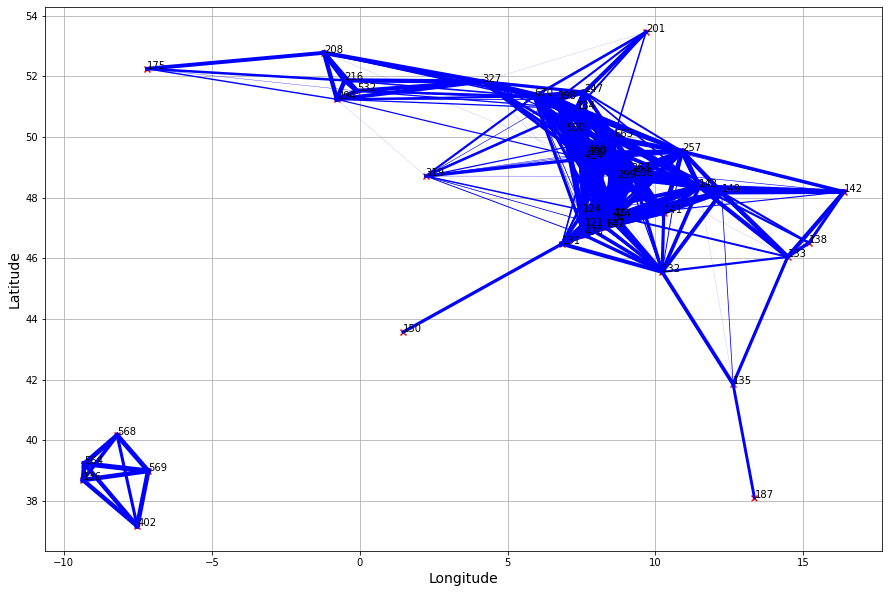

In [19]:
# Investigate pairs of good stations

# calculate pairs using TrackCollection class method
good_pairs = tracks.get_pairs([x for x in itertools.combinations(good_sensors, r=2)])

st = Stations(good_sensors.tolist())
st.st_params = {}

figsize(15, 10)
f = plt.figure()
ax = f.add_subplot(111)

# Print pairs (the more pairs - the thicker the line)
for key in good_pairs.keys():
    x1 = st.locs(key[0])[:2]
    x2 = st.locs(key[1])[:2]
    ax.plot([x1[1], x2[1]], [x1[0], x2[0]], 'b-', lw=max(0.1, np.log10(good_pairs[key])))
    
# Plot stations
st.plot(ax)

ax.grid()
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

## Investigate dispersion of points for pairs of good stations (before synchronization)

Approx Median error [m]: 127.73591038239829


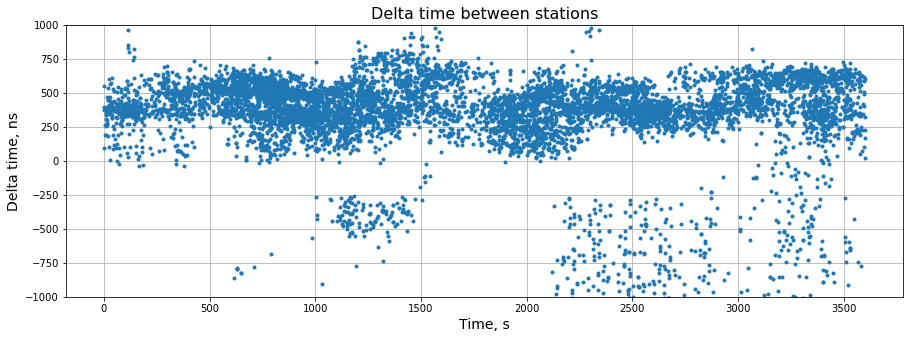

In [25]:
## Example of high dispersion

figsize(15, 5)
_ = tracks.get_aircraft_times(st, (175, 208), verbose=True)

Approx Median error [m]: 36195.541531469644


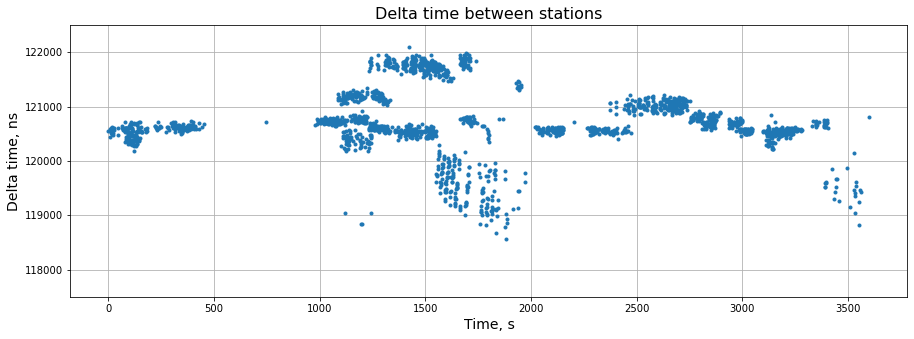

In [35]:
## Another example of high dispersion and delta time shift

figsize(15, 5)
_ = tracks.get_aircraft_times(st, (132, 470), verbose=True, ylim=[1.175e5, 1.225e5])

Approx Median error [m]: 22.52854756079614


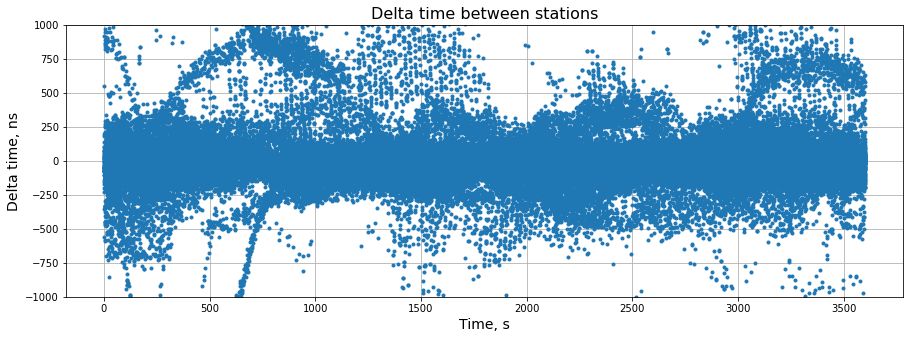

In [36]:
## Good example

figsize(15, 5)
_ = tracks.get_aircraft_times(st, (208, 216), verbose=True)

## Selection of first set of good stations

<p style="font-size:16px">So, we can see that not all 'good' stations are good enough in order to use them for synchronization of all other stations. I decided to select the best 35 stations based on:
    <ul>
     <li>dispersion of points in pairs;</li>
     <li>all good stations have to have pairs with several other good stations, so that I can optimize their location</li></ul></p>

In [41]:
## First set of good stations

first_set = list(set(good_sensors).difference([175, 532, 319, 201, 131, 150, 132, 142, 135, 187]))
fst = Stations(first_set)
fst.st_params = {}

print('Number of good stations:', len(fst.inventory))
fst

Number of good stations: 35


Stations: 10, 14, 121, 124, 130, 133, 134, 136, 138, 141, 143, 147, 149, 208, 216, 247, 257, 263, 294, 299, 327, 398, 402, 414, 460, 470, 474, 550, 564, 568, 569, 598, 632, 663, 670

Text(0, 0.5, 'Latitude')

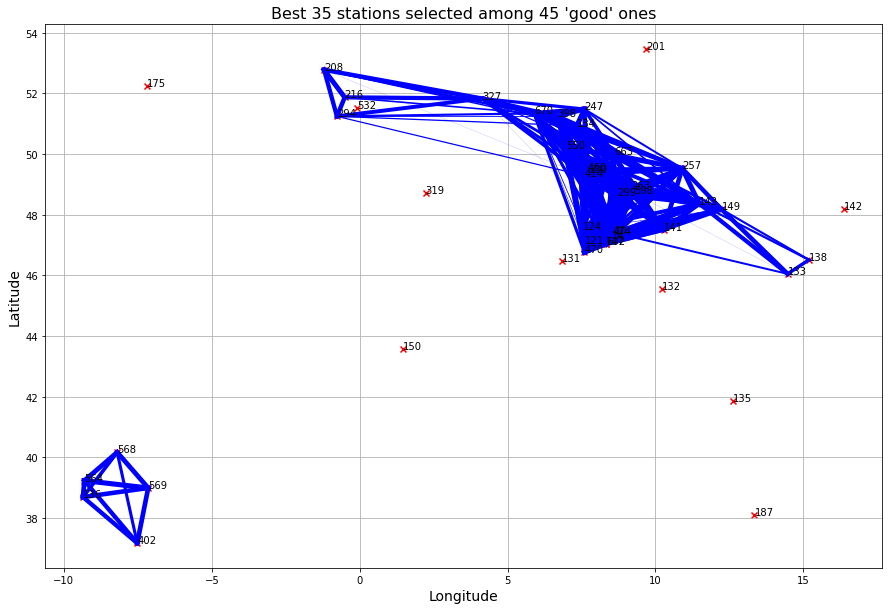

In [44]:
# Pairs of good stations

# calculate pairs using TrackCollection class method
good_pairs = tracks.get_pairs([x for x in itertools.combinations(fst.inventory, r=2)])

figsize(15, 10)
f = plt.figure()
ax = f.add_subplot(111)

# Print pairs (the more pairs - the thicker the line)
for key in good_pairs.keys():
    x1 = st.locs(key[0])[:2]
    x2 = st.locs(key[1])[:2]
    ax.plot([x1[1], x2[1]], [x1[0], x2[0]], 'b-', lw=max(0.1, np.log10(good_pairs[key])))
    
# Plot stations
st.plot(ax)

ax.grid()
ax.set_title("Best 35 stations selected among 45 'good' ones", fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

In [45]:
## Previous result of location optimization for all good stations

A0_B = [-3.32528999, -3.68096287]
        
shifts = [-6.70353109e+00, -6.78175041e+00,
          -8.85651485e+00, -6.68406510e+00, -6.83738160e+00, -1.00175876e+01,
          -6.59772607e+00, -6.40522155e+00, -1.01702946e+01, -6.65719096e+00,
          -9.77361843e+00, -6.44985716e+00, -6.55504358e+00, -9.90328225e+00,
          -6.74196271e+00, -6.58282039e+00, -6.60310659e+00, -6.18299098e+00,
          -9.40858022e+00, -8.33264694e+00, -8.49477768e+00, -7.25578794e+00,
          -9.12738044e+00, -6.91245943e+00, -9.47435011e+00, -6.88527017e+00,
          -7.00339397e+00, -6.67600873e+00, -4.47111523e+00, -7.27854380e+00,
          -8.63438588e+00, -6.73888182e+00, -3.91839960e+00, -3.91818238e+00,
          -3.91745643e+00, -3.91796856e+00, -6.62463358e+00, -3.91827944e+00,
          -6.78808008e+00, -6.75338188e+00, -6.71686038e+00, -6.80234129e+00,
          -6.60289941e+00, -6.86001862e+00, -8.78614800e+00]

In [46]:
## Select proper shifts for the first set

st = Stations(good_sensors.tolist())

fshifts = []

for i, s in enumerate(st.inventory):
    if s in fst.inventory:
        fshifts.append(shifts[i])
        
len(fshifts)

35

In [47]:
from src.solvers import GoodStationsSolver

opt = GoodStationsSolver()
opt.prepare_data(tracks, fst, threshold=1500*1e-9, N=20000)

 68%|██████▊   | 1788/2629 [07:28<03:30,  3.99it/s]


KeyboardInterrupt: 

In [ ]:
opt.optimize(fst, A0_B[0], A0_B[1], fshifts, optimize_locations_flag=True)

In [48]:
# result of run 1500ns, 20000 points
A0_B = [pow(10, y) for y in [-3.43667365e+00, -4.06472353e+00]]
        
shifts = [pow(10, y) for y in [-7.11434081e+00, -7.22819731e+00,
       -8.83870731e+00, -7.06997492e+00, -7.08268100e+00, -7.00938609e+00,
       -1.01729574e+01, -9.77355387e+00, -7.11141541e+00, -6.76659381e+00,
       -7.22278746e+00, -6.92709914e+00, -7.03996985e+00, -7.75427061e+00,
       -9.11757476e+00, -6.89056754e+00, -9.46801783e+00, -7.21695015e+00,
       -7.33769829e+00, -6.91792998e+00, -7.36301447e+00, -8.56531160e+00,
       -6.75218732e+00, -3.91861080e+00, -3.91835193e+00, -3.91807496e+00,
       -3.91839432e+00, -3.91839479e+00, -6.81686631e+00, -6.82750234e+00,
       -6.72162050e+00, -7.12386142e+00, -7.05804971e+00, -6.96517205e+00,
       -8.76157876e+00]]
        
locations = [4.74003907e+01,  8.63053167e+00,  4.30683845e+02,
        4.72482948e+01,  8.52974042e+00,  6.25144672e+02,  4.70704381e+01,
        7.62059643e+00,  5.60811656e+02,  4.75381564e+01,  7.55951888e+00,
        3.52785754e+02,  4.94248656e+01,  7.75277186e+00,  2.92222132e+02,
        4.60500229e+01,  1.44691210e+01,  3.46882083e+02,  5.09371903e+01,
        7.35395305e+00,  2.62305822e+02,  3.86893683e+01, -9.35489820e+00,
        7.37338821e+01,  4.65138771e+01,  1.51881293e+01,  1.57734454e+03,
        4.75119828e+01,  1.02801412e+01,  7.54540937e+02,  4.83658601e+01,
        1.14784277e+01,  4.92925814e+02,  4.70361216e+01,  8.32399853e+00,
        4.79550824e+02,  4.81787456e+01,  1.22354460e+01,  5.29391996e+02,
        5.27809770e+01, -1.20441490e+00,  4.27620402e+01,  5.18724544e+01,
       -5.06989464e-01,  1.81262795e+02,  5.14865736e+01,  7.59784956e+00,
        1.46600666e+02,  4.95296172e+01,  1.09061941e+01,  3.06901503e+02,
        4.88913513e+01,  9.17767383e+00,  3.03714814e+02,  5.12458814e+01,
       -7.68625186e-01,  1.08587905e+02,  4.86569294e+01,  8.72482551e+00,
        3.60914642e+02,  5.18331813e+01,  4.14276178e+00,  1.09823167e+01,
        5.12427012e+01,  6.68497250e+00,  4.39053786e+01,  3.71713545e+01,
       -7.52168839e+00,  6.65337662e+01,  4.92876342e+01,  7.60384112e+00,
        4.10653429e+02,  4.94716113e+01,  7.69651939e+00,  2.67632204e+02,
        4.67624871e+01,  7.60048572e+00,  5.90875517e+02,  4.73778257e+01,
        8.55247058e+00,  5.03952969e+02,  5.02060722e+01,  6.97846214e+00,
        4.34708535e+02,  3.92316619e+01, -9.30812764e+00,  6.39646694e+01,
        4.01651070e+01, -8.19932381e+00,  1.80718597e+02,  3.89892473e+01,
       -7.15020320e+00,  2.41443914e+02,  4.87109833e+01,  9.26528906e+00,
        3.55448500e+02,  4.70362217e+01,  8.32402692e+00,  4.61417533e+02,
        4.99882346e+01,  8.59180901e+00,  1.34775358e+02,  5.13416634e+01,
        5.89330577e+00,  3.13178694e+01]

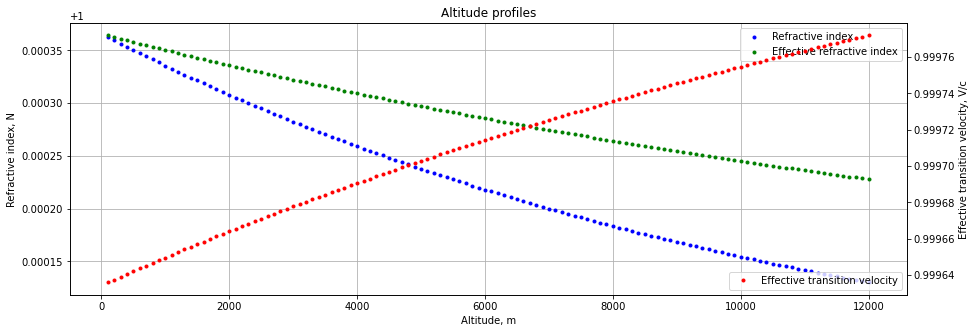

In [49]:
figsize(15, 5)
plot_altitude_profiles(A0_B[0], A0_B[1])

{10: 26.972921706825314, 14: 1.2373691626156011, 121: 10.101889679163856, 124: 4.917471422201447, 130: 12.538348310179577, 133: 15.479597893980262, 134: 16.37659567108985, 136: 3.0671163821215264, 138: 14.27399992960039, 141: 6.252987051149856, 143: 5.034644834979192, 147: 5.239267830764273, 149: 9.429367809648118, 208: 13.30641248081805, 216: 11.967074219084193, 247: 7.545576381963264, 257: 7.860854219275838, 263: 10.09637227356849, 294: 24.677609767719893, 299: 4.6349644893435675, 327: 21.693702605405228, 398: 12.50507283660866, 402: 8.676768415797875, 414: 12.365836006893417, 460: 3.589882234819297, 470: 9.700810750935144, 474: 1.3457164363338003, 550: 7.058806047302804, 564: 13.322491769281593, 568: 9.8469931902321, 569: 12.240825250334142, 598: 7.96023781427692, 632: 10.215212516353153, 663: 4.1835177807821875, 670: 10.262004196392303}


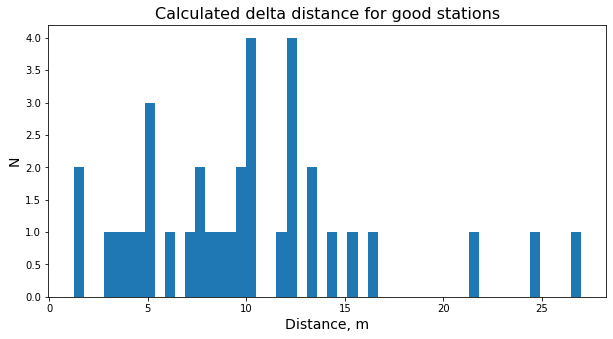

In [57]:
distances = {}
for i, s in enumerate(fst.inventory):
    distances[s] = dist3d(P3(*locations[3*i:3*i+3]), fst.p3s(s))
    
print(distances)

figsize(10, 5)
_ = plt.hist(distances.values(), bins=50)
plt.title('Calculated delta distance for good stations', fontsize=16)
plt.xlabel('Distance, m', fontsize=14)
_ = plt.ylabel('N', fontsize=14)

In [58]:
fst.A0 = A0_B[0]
fst.B = A0_B[1]

st_params = {}

for i, s in enumerate(fst.inventory):
    fst.update_location(int(s), locations[3*i:3*i+3])
    st_params[str(s)] = {'location': locations[3*i:3*i+3],
                         'shift':shifts[i]}
    
fst.st_params = st_params
fst

Stations: 10, 14, 121, 124, 130, 133, 134, 136, 138, 141, 143, 147, 149, 208, 216, 247, 257, 263, 294, 299, 327, 398, 402, 414, 460, 470, 474, 550, 564, 568, 569, 598, 632, 663, 670

Approx Median error [m]: 18.25628714868799


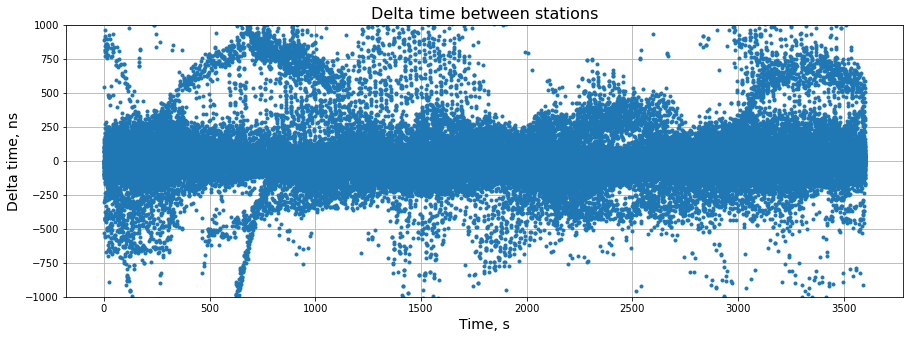

In [60]:
figsize(15, 5)
_ = tracks.get_aircraft_times(fst, (208, 216), verbose=True)

Approx Median error [m]: 24.618702809675597


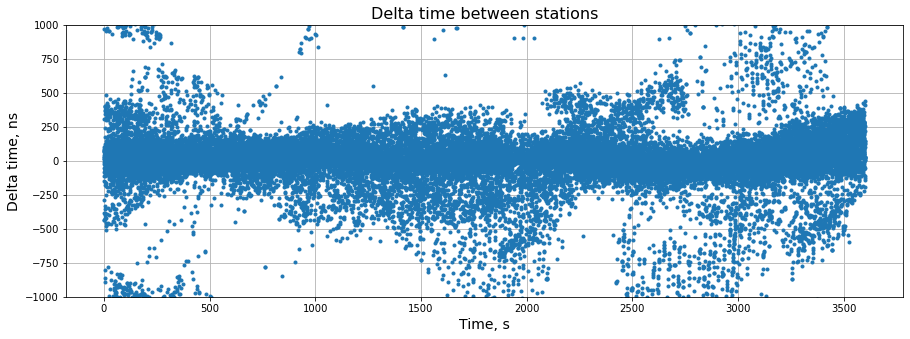

In [62]:
figsize(15, 5)
_ = tracks.get_aircraft_times(fst, (550, 670), verbose=True)